In [1]:
from uncertainties import unumpy, ufloat
import numpy as np
import matplotlib.pyplot as plt
import pywapor.et_look_v2_v3 as ETLook
import xarray as xr
import os
import datetime as dt
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import tqdm
import seaborn as sns
%run ../Functions.ipynb

<>:31: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1203251/2858539060.py:31: SyntaxWarning: invalid escape sequence '\c'
  text = f'$y = {m:.2f} \cdot x + {b:.2f}$'


# Create 500 realisations

In [2]:
def sampling_LHS(es_mean_dts,es_std_dts,num_simulations=100,seed=42):
    # GET MIN MAX 
    # get daily mean and spread
    es_mean=es_mean_dts.resample(time='1D').mean().isel(time=0)
    es_std=es_std_dts.resample(time='1D').mean().isel(time=0)
    
    # calc 3-hourly RH
    t2m_k=da_to_uarray(es_mean_dts.t2m,es_std_dts.t2m)
    d2m_k=da_to_uarray(es_mean_dts.d2m,es_std_dts.d2m)
    rh=calc_RH(d2m_k,t2m_k,unit='K',source=1)
    
    ## get daily mean and spread of RHmin, RHmax
    tmin=t2m_k.min(axis=0)
    tmax=t2m_k.max(axis=0)
    rhmin=rh[2:7].min(axis=0)
    rhmax=rh[2:7].max(axis=0)
    # INPUT DATA    
    ds={}
    ## solar radiation
    ds["ra_24_J"] = get_LHS_simulations(es_mean.ssrd,es_std.ssrd,num_simulations)
    ds["ra_24"] = ds["ra_24_J"]/(3*3600) #convert daily average 3hourly J/m2 to total daily W/m2
    
    ## air temperature [K]
    ds["t_air_k_24"] = get_LHS_simulations(es_mean.t2m,es_std.t2m,num_simulations)
    ds["t_air_min_k_24"] = get_LHS_simulations(unumpy.nominal_values(tmin),
                                               unumpy.std_devs(tmin),num_simulations)
    ds["t_air_max_k_24"] = get_LHS_simulations(unumpy.nominal_values(tmax),
                                               unumpy.std_devs(tmax),num_simulations)
    ## air pressure [Pa]
    ds["p_air_24_pa"] = get_LHS_simulations(es_mean.sp,es_std.sp,num_simulations)
    
    ## windspeed at 10m [m/s]
    ds["u10m_24"] = get_LHS_simulations(es_mean.u10,es_std.u10,num_simulations)
    ds["v10m_24"] = get_LHS_simulations(es_mean.v10,es_std.v10,num_simulations)
    
    ## relative humidity or specific humidity or dew-point temperature
    # ds["qv_24"] = unumpy.uarray([[1, 2],[5, 3]], [[0.05, 0.004],[0.01, 0.002]])
    ds["rh_min_24"]=get_LHS_simulations(unumpy.nominal_values(rhmin),
                                               unumpy.std_devs(rhmin),num_simulations)
    ds["rh_max_24"]=get_LHS_simulations(unumpy.nominal_values(rhmax),
                                               unumpy.std_devs(rhmax),num_simulations)
    ds["t_dew_k_24"] = get_LHS_simulations(es_mean.d2m,es_std.d2m,num_simulations)
    
    # STATIC INPUT
    da_temp = es_mean.t2m
    ## day of the year
    date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    day_of_year = date_obj.timetuple().tm_yday
    ds["doy"] = get_deterministic_arrays(day_of_year*np.ones_like(da_temp.values),num_simulations)
    
    ## latitude
    latitudes = da_temp['latitude']
    latitude_array = xr.DataArray(latitudes, dims=['latitude'])
    latitude_grid = latitude_array.broadcast_like(da_temp) # Use xarray broadcasting to create an array where each element of the array is the latitude value
    ds["y"] = get_deterministic_arrays(latitude_grid.values,num_simulations)
    
    # PARAMETERS
    ds["vp_slope"]= 0.14
    ds["vp_offset"]= 0.34
    ds["lw_slope"]= 1.35
    ds["lw_offset"]= -0.35
    ds["r0_grass"] = 0.23
    # ds["k_RS"] = 0.16 # correction for air mass FAO-56 Equ50
    return ds

In [3]:
date = '2018-06-01'
folder = r'./data/ERA5_Ensemble'
save_folder = r'./data/ERA5-RET_MCM500'
shapefile_path = r"./data/WaPOR_L1_v2_mask.shp"
seed = 42
np.random.seed(seed)
num_simulations = 500
mask=shapefile_path

In [4]:
es_mean_fhs = glob.glob(os.path.join(folder, f'ensemble_mean_{date}*.nc'))
es_mean_dts = xr.open_mfdataset(es_mean_fhs)    
es_std_fhs = glob.glob(os.path.join(folder, f'ensemble_spread_{date}*.nc'))
es_std_dts = xr.open_mfdataset(es_std_fhs)
da_temp=es_mean_dts.t2m[0]
ds = sampling_LHS(es_mean_dts,es_std_dts,num_simulations=num_simulations,seed=seed)
ds_out=calc_RET_FAO(ds,ret_only=True)

/tmp/ipykernel_1203251/2638014781.py:85: RuntimeWarning: invalid value encountered in sqrt
  (ds["vp_offset"]-ds["vp_slope"]*(ds['vp_24']**(1/2)))*\


In [5]:
ds_taylor = xr.open_dataset(f'./data/ERA5-RET_Taylor/{date}.nc')

In [6]:
mask = r"./data/WaPOR_L1_v2_mask.shp"

# Kolmogorov-Smirnov (K-S) Test
The Kolmogorov-Smirnov test compares the empirical distribution function of the sample with the cumulative distribution function of the specified normal distribution.

In [7]:
import numpy as np
from scipy.stats import kstest
from joblib import Parallel, delayed
import matplotlib.colors as mcolors
import scipy.stats as stats

In [8]:
def test_normality(sample, mean, std,method=1):
    # Perform the K-S test for the given mean and standard deviation
    ks_statistic, p_value = kstest(sample, 'norm', args=(mean, std))
    return p_value

In [9]:
MC=ds_out.reshape(500,-1)
mean = ds_taylor['mean'].values.reshape(-1)
std = ds_taylor['std'].values.reshape(-1)

# calc p-value K-S test
p_values = Parallel(n_jobs=-1)(
    delayed(test_normality)(MC[:,i], mean[i], std[i]) 
    for i in range(MC.shape[1])
)
p_values_grid = np.array(p_values).reshape(161, 181)
alpha = 0.05 #significance
rejected_normality = p_values_grid < (alpha / (161 * 181))  # Bonferroni correction

In [10]:
da =  xr.DataArray(rejected_normality,
                 dims=ds_taylor['mean'].dims,
                 coords=ds_taylor['mean'].coords)
amask = np.isnan(ds_taylor['mean'])
da = xr.where(amask, np.nan,da) 

In [11]:
points=[
    [80,35], #x, y
    [100,60], #x, y
    [100,120], #x, y
]

/tmp/ipykernel_1203251/3496738349.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=5,color='black')


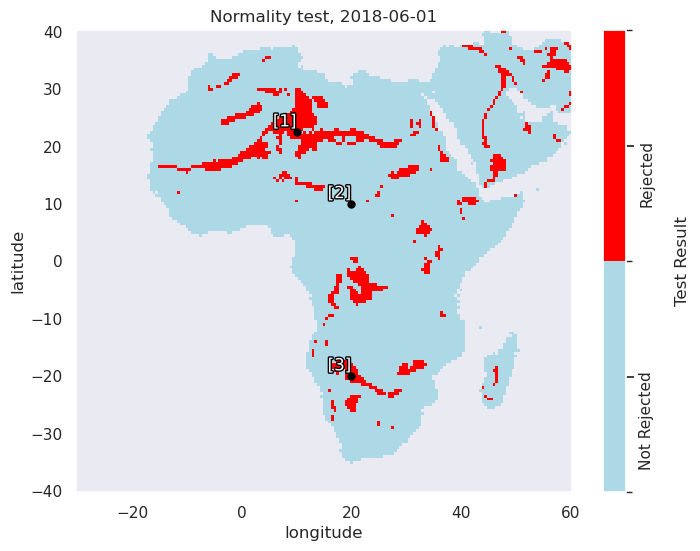

In [13]:
sns.set_theme(style="darkgrid")
import matplotlib.patheffects as path_effects
###
cmap = mcolors.ListedColormap(['lightblue', 'red'])  # Colors for not rejected and rejected
bounds = [0, 0.5, 1]  # Define boundaries for the two colors
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(8, 6))
im=da.plot(cmap=cmap, norm=norm,add_colorbar=False,ax=ax)

# Create a colorbar with custom labels
cbar = plt.colorbar(im, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Not Rejected', 'Rejected'])
# Rotate ytick labels on the colorbar
for tick_label in cbar.ax.get_yticklabels():
    tick_label.set_rotation(90)
cbar.set_label('Test Result', rotation=90, labelpad=15)
# add points
for i, point in enumerate(points):
    [x,y]=point
    [lat,lon]=[da.latitude[y].values,da.longitude[x].values]
    ax.plot(lon, lat, 'ro', markersize=5,color='black')
    text=ax.text(lon, lat+1, f'[{i+1}]', fontsize=12, ha='right',color='white')
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                           path_effects.Normal()])
plt.title(f"Normality test, {date}")
plt.savefig('./figures/norm_test_180601_2.png',dpi=300,bbox_inches='tight')
plt.show()

# Q-Q plot

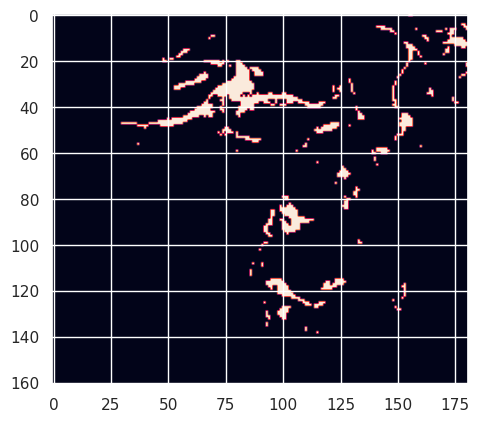

In [33]:
plt.imshow(rejected_normality)

In [34]:
# x,y= 80,35
x,y= 100,120

rejected_normality[y,x]

np.True_

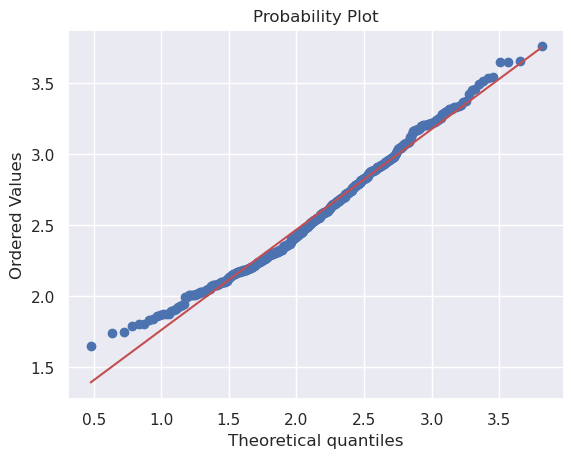

In [35]:
data=ds_out[:,y,x]
mean=ds_taylor['mean'].values[y,x]
std= ds_taylor['std'].values[y,x]
stats.probplot(data, dist="norm", sparams=(mean, std), plot=plt)
plt.show()

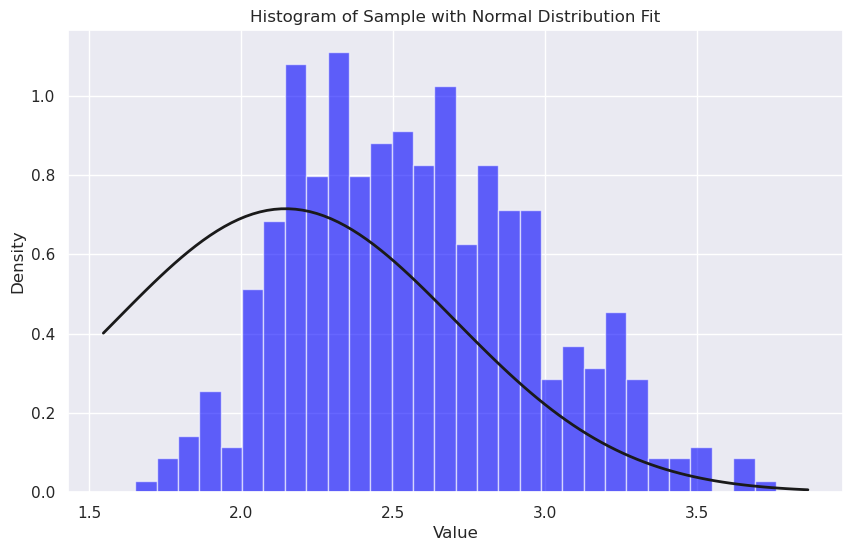

In [36]:
# Plot the histogram of the sample
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='blue')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)

plt.plot(x, p, 'k', linewidth=2)

# Add titles and labels
plt.title('Histogram of Sample with Normal Distribution Fit')
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()


In [37]:
x,y= 100,60
rejected_normality[y,x]

np.False_

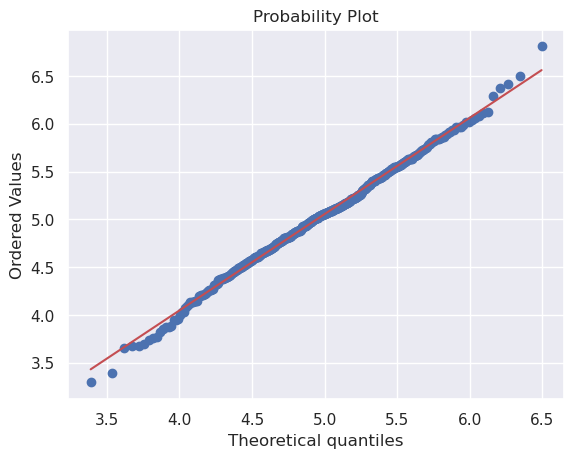

In [38]:
data=ds_out[:,y,x]
mean=ds_taylor['mean'].values[y,x]
std= ds_taylor['std'].values[y,x]
stats.probplot(data, dist="norm", sparams=(mean, std), plot=plt)
plt.show()

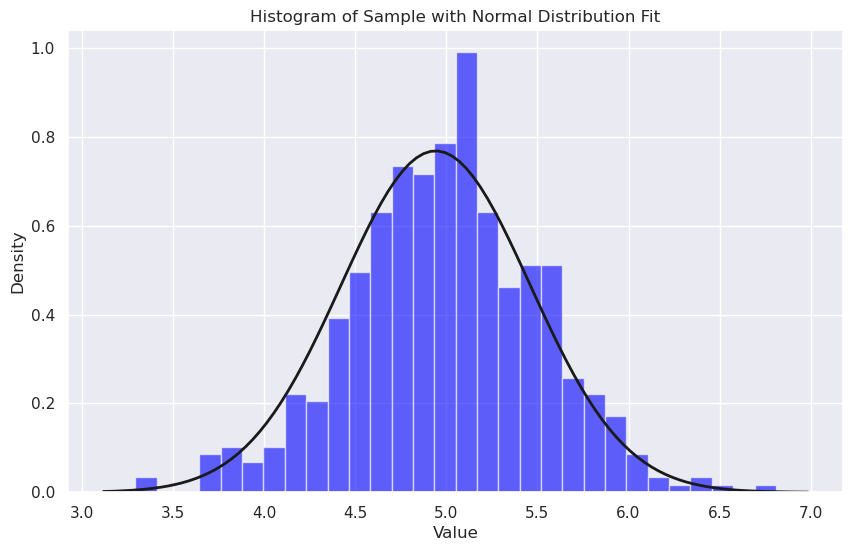

In [39]:
# Plot the histogram of the sample
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='blue')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)

plt.plot(x, p, 'k', linewidth=2)

# Add titles and labels
plt.title('Histogram of Sample with Normal Distribution Fit')
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_153795/583749207.py:21: SyntaxWarning: invalid escape sequence '\m'
  axs[1].set_title('Histogram of MC sample with $N(\mu,\sigma^2$) fit')
/tmp/ipykernel_153795/583749207.py:25: SyntaxWarning: invalid escape sequence '\m'
  axs[1].set_xlabel('$\mathregular{ET_o}$ [mm day$^{-1}$]')


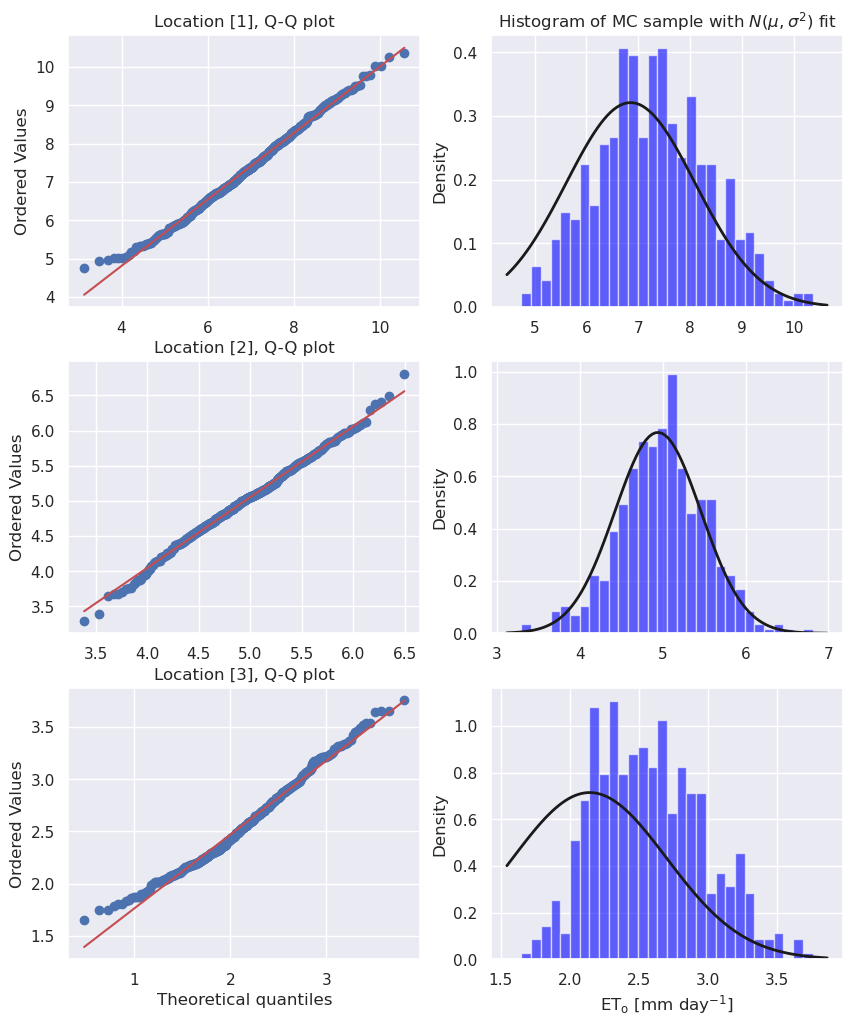

In [41]:
points=[
    [80,35], #x, y
    [100,60], #x, y
    [100,120], #x, y
]
fig,axss=plt.subplots(3,2,figsize=(10, 12))
for i,point in enumerate(points):
    axs=axss[i,:]
    [x,y]=point    
    data=ds_out[:,y,x]
    mean=ds_taylor['mean'].values[y,x]
    std= ds_taylor['std'].values[y,x]
    stats.probplot(data, dist="norm", sparams=(mean, std), plot=axs[0])
    count, bins, ignored = axs[1].hist(data, bins=30, density=True, alpha=0.6, color='blue')
    xmin, xmax =  axs[1].get_xlim()
    v = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(v, mean, std)
    axs[1].plot(v, p, 'k', linewidth=2)
    axs[0].set_title(f'Location [{i+1}], Q-Q plot')
    if i == 0:
        axs[1].set_title('Histogram of MC sample with $N(\mu,\sigma^2$) fit')
    else:
        axs[1].set_title('')
    if i == 2:
        axs[1].set_xlabel('$\mathregular{ET_o}$ [mm day$^{-1}$]')
    else:
        axs[1].set_xlabel('')
        axs[0].set_xlabel('')
    axs[1].set_ylabel('Density')    
plt.savefig('./figures/QQ_hist_points_180601.png',dpi=300,bbox_inches='tight')
plt.show()

<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1203251/463959424.py:79: SyntaxWarning: invalid escape sequence '\m'
  ax_hist.set_xlabel('$\mathregular{ET_o}$ [mm day$^{-1}$]')
/tmp/ipykernel_1203251/463959424.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax_map.plot(lon, lat, 'ro', markersize=5, color='black')


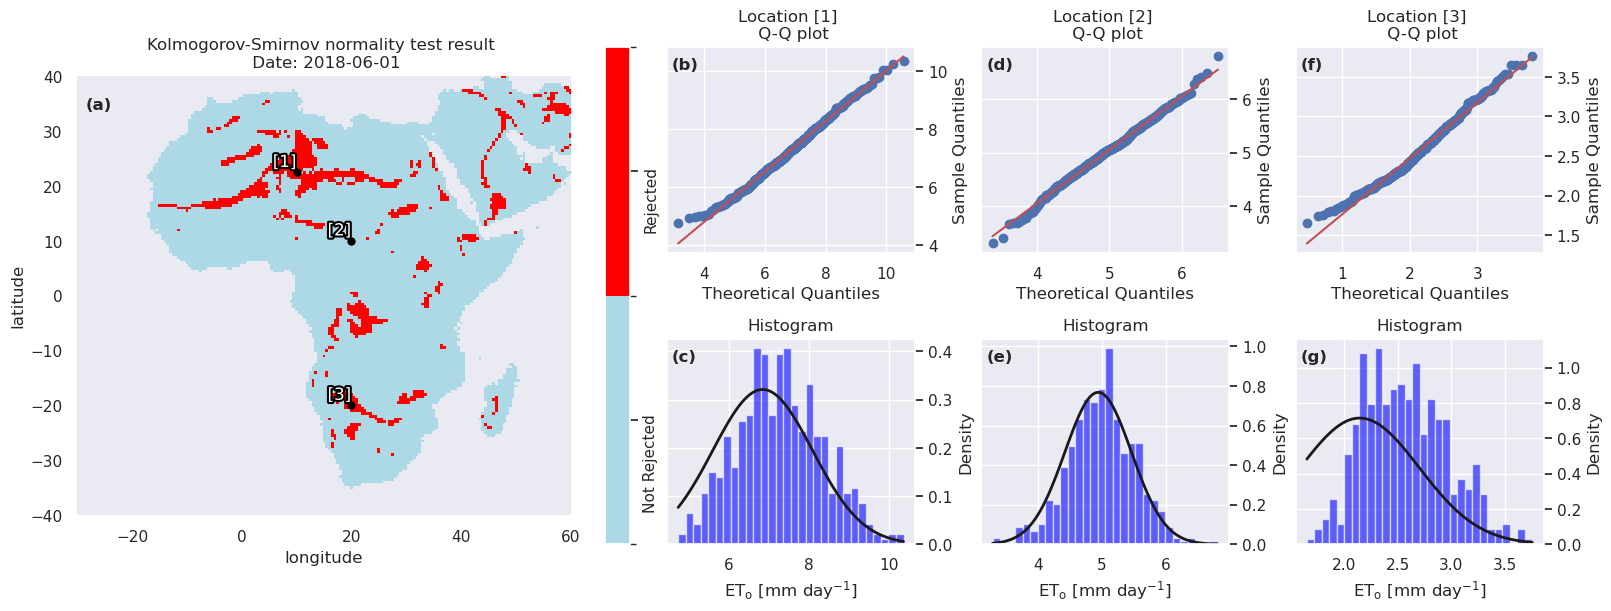

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats
import numpy as np
import string

sns.set_theme(style="darkgrid")

# === CREATE FIGURE WITH CONSTRAINED LAYOUT ===
fig = plt.figure(figsize=(16, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 5)  # 2 rows, 5 columns: 2 for map, 3 for plots

# Generate internal labels: (a), (b), ..., (h)
internal_labels = list(string.ascii_lowercase)
label_index = 0  # will increment as we go

# ==== PANEL (a) — MAP ====
ax_map = fig.add_subplot(gs[:, 0:2])  # Span both rows for the map

cmap = mcolors.ListedColormap(['lightblue', 'red'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = da.plot(cmap=cmap, norm=norm, add_colorbar=False, ax=ax_map)
cbar = plt.colorbar(im, ax=ax_map, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Not Rejected', 'Rejected'])
# cbar.set_label('Test Result', rotation=90, labelpad=15)
# Rotate ytick labels
for tick_label in cbar.ax.get_yticklabels():
    tick_label.set_rotation(90)

# Add points
for i, point in enumerate(points):
    [x, y] = point
    [lat, lon] = [da.latitude[y].values, da.longitude[x].values]
    ax_map.plot(lon, lat, 'ro', markersize=5, color='black')
    text = ax_map.text(lon, lat + 1, f'[{i + 1}]', fontsize=12, ha='right', color='white')
    text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

ax_map.set_title(f"Kolmogorov-Smirnov normality test result \n Date: {date}")
ax_map.set_aspect('equal')  # Keep 1:1 aspect ratio
ax_map.text(0.02, 0.95, f"({internal_labels[label_index]})", transform=ax_map.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')
label_index += 1

# ==== PANEL (b) — TRANSPOSED Q-Q and HISTOGRAMS ====
for i, point in enumerate(points):
    # Q-Q plot on top row
    ax_qq = fig.add_subplot(gs[0, 2 + i])
    # Histogram on bottom row
    ax_hist = fig.add_subplot(gs[1, 2 + i])

    [x, y] = point
    data = ds_out[:, y, x]
    mean = ds_taylor['mean'].values[y, x]
    std = ds_taylor['std'].values[y, x]

    # QQ plot
    stats.probplot(data, dist="norm", sparams=(mean, std), plot=ax_qq)
    ax_qq.set_title(f'Location [{i+1}] \n Q-Q plot')
    ax_qq.set_xlabel('Theoretical Quantiles')
    ax_qq.set_ylabel('Sample Quantiles')
    ax_qq.yaxis.tick_right()
    ax_qq.yaxis.set_label_position("right")
    ax_qq.text(0.02, 0.95, f"({internal_labels[label_index]})", transform=ax_qq.transAxes,
               fontsize=12, fontweight='bold', va='top', ha='left')
    label_index += 1
    # Histogram
    count, bins, ignored = ax_hist.hist(data, bins=30, density=True, alpha=0.6, color='blue')
    v = np.linspace(bins[0], bins[-1], 100)
    p = stats.norm.pdf(v, mean, std)
    ax_hist.plot(v, p, 'k', linewidth=2)
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel('$\mathregular{ET_o}$ [mm day$^{-1}$]')
    ax_hist.set_ylabel('Density')
    ax_hist.yaxis.tick_right()
    ax_hist.yaxis.set_label_position("right")
    ax_hist.text(0.02, 0.95, f"({internal_labels[label_index]})", transform=ax_hist.transAxes,
                 fontsize=12, fontweight='bold', va='top', ha='left')
    label_index += 1
# === SUBPLOT LABELS ===
# ax_map.text(-0.05, 1.02, "(a)", transform=ax_map.transAxes, fontsize=14, fontweight='bold', va='bottom')
# fig.text(0.42, 0.96, "(b) Q-Q plots and histograms", fontsize=14, fontweight='bold')

# === SAVE AND SHOW ===
plt.savefig('./figures/combined_panel_transposed_180601.png', dpi=300, bbox_inches='tight')
plt.show()


<>:110: SyntaxWarning: invalid escape sequence '\m'
<>:114: SyntaxWarning: invalid escape sequence '\m'
<>:110: SyntaxWarning: invalid escape sequence '\m'
<>:114: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1203251/3822137653.py:110: SyntaxWarning: invalid escape sequence '\m'
  ax_hist.set_title('Histogram of MC sample \n with $N(\mu,\sigma^2$) fit')
/tmp/ipykernel_1203251/3822137653.py:114: SyntaxWarning: invalid escape sequence '\m'
  ax_hist.set_xlabel('$\mathregular{ET_o}$ [mm day$^{-1}$]')
/tmp/ipykernel_1203251/3822137653.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax_map.plot(lon, lat, 'ro', markersize=5, color='black')


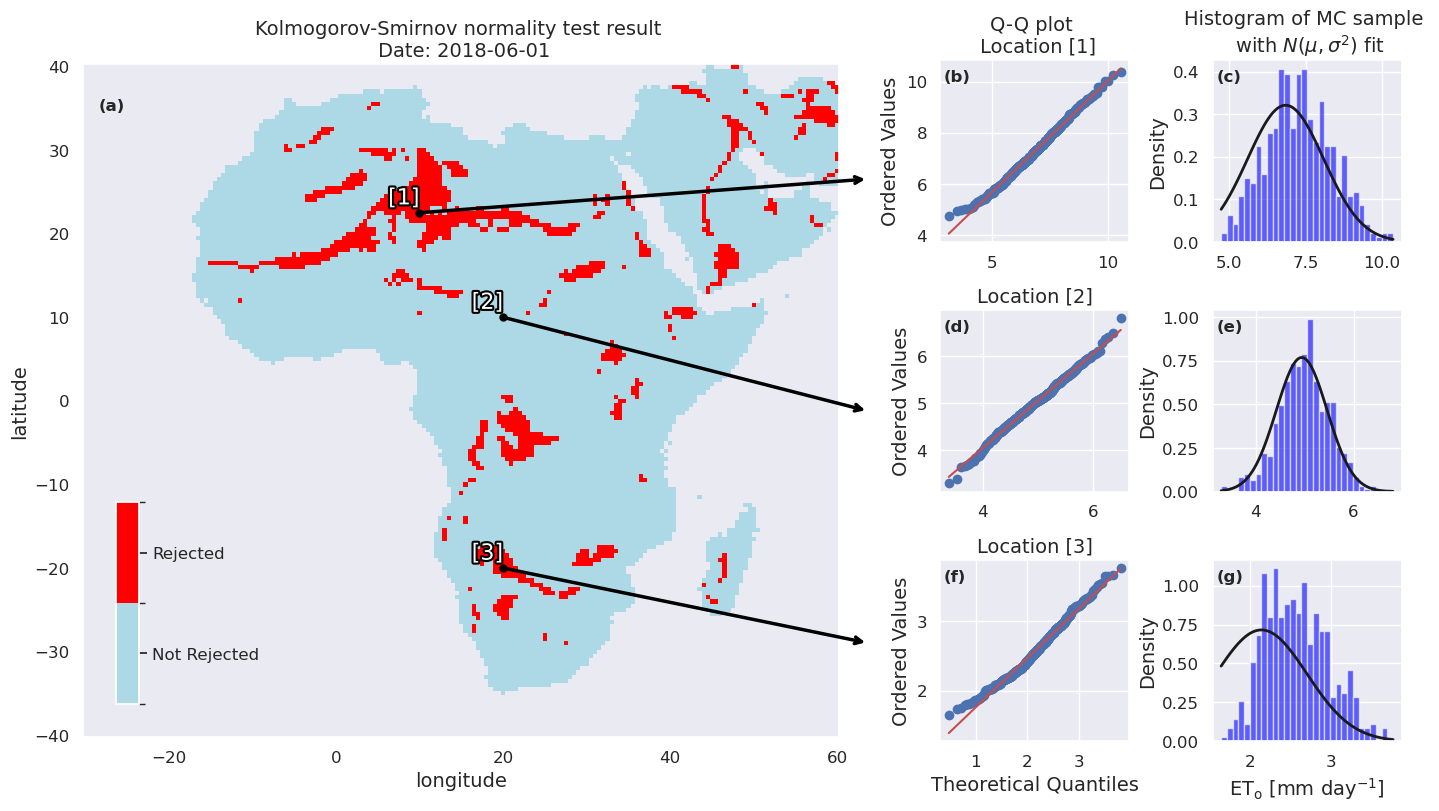

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats
import numpy as np

sns.set_theme(style="darkgrid")
import matplotlib as mpl

import matplotlib as mpl

mpl.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 16,
})


# === CREATE FIGURE WITH CONSTRAINED LAYOUT ===
fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = fig.add_gridspec(3, 6)  # 4 columns: 4 for map, 2 for QQ/histograms
# Generate internal labels: (a), (b), ..., (h)
internal_labels = list(string.ascii_lowercase)
label_index = 0  # will increment as we go

# ==== PANEL (a) — MAP ====
ax_map = fig.add_subplot(gs[:, 0:4])  # Wider section for map

cmap = mcolors.ListedColormap(['lightblue', 'red'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = da.plot(cmap=cmap, norm=norm, add_colorbar=False, ax=ax_map)

#colorbar
# cbar = plt.colorbar(im, ax=ax_map, ticks=[0.25, 0.75])
# cbar.ax.set_yticklabels(['Not Rejected', 'Rejected'])

# # Rotate ytick labels
# for tick_label in cbar.ax.get_yticklabels():
#     tick_label.set_rotation(90)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create an inset axis in the lower-left inside the map for the colorbar
cax = inset_axes(ax_map,
                 width="3%",   # narrow bar
                 height="30%",  # half size or smaller
                 loc='lower left',
                 borderpad=2)

# Create colorbar in the inset axis
cbar = plt.colorbar(im, cax=cax, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Not Rejected', 'Rejected'])

# Optional: reduce tick label size if it overlaps
# cbar.ax.tick_params(labelsize=7)


# Add points
for i, point in enumerate(points):
    [x, y] = point
    [lat, lon] = [da.latitude[y].values, da.longitude[x].values]
    ax_map.plot(lon, lat, 'ro', markersize=5, color='black')
    text = ax_map.text(lon, lat + 1, f'[{i + 1}]', fontsize=16, ha='right', color='white')
    text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

ax_map.set_title((f"Kolmogorov-Smirnov normality test result \n Date: {date}"))
ax_map.set_aspect('equal')  # Enforce 1:1 aspect ratio
ax_map.text(0.02, 0.95, f"({internal_labels[label_index]})", transform=ax_map.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')
label_index += 1
# ==== PANEL (b) — QQ & Histograms ====
for i, point in enumerate(points):
    ax_qq = fig.add_subplot(gs[i, 4])
    ax_hist = fig.add_subplot(gs[i, 5])
    [x, y] = point
    data = ds_out[:, y, x]
    mean = ds_taylor['mean'].values[y, x]
    std = ds_taylor['std'].values[y, x]

    # QQ plot
    stats.probplot(data, dist="norm", sparams=(mean, std), plot=ax_qq)
    ax_qq.set_title(f'Q-Q plot \n Location [{i+1}]' if i == 0 else f'Location [{i+1}]')
    ax_qq.text(0.02, 0.95, f"({internal_labels[label_index]})", transform=ax_qq.transAxes,
               fontsize=12, fontweight='bold', va='top', ha='left')
    label_index += 1    
    if i < 2:
        ax_qq.set_xlabel('')
    else:
        ax_qq.set_xlabel('Theoretical Quantiles')

    # Histogram
    count, bins, ignored = ax_hist.hist(data, bins=30, density=True, alpha=0.6, color='blue')
    v = np.linspace(bins[0], bins[-1], 100)
    p = stats.norm.pdf(v, mean, std)
    ax_hist.plot(v, p, 'k', linewidth=2)
    ax_hist.text(0.02, 0.95, f"({internal_labels[label_index]})", transform=ax_hist.transAxes,
                 fontsize=12, fontweight='bold', va='top', ha='left')
    label_index += 1    
    if i == 0:
        ax_hist.set_title('Histogram of MC sample \n with $N(\mu,\sigma^2$) fit')
    if i < 2:
        ax_hist.set_xlabel('')
    else:
        ax_hist.set_xlabel('$\mathregular{ET_o}$ [mm day$^{-1}$]')
    ax_hist.set_ylabel('Density')

# === ANNOTATED ARROWS ===
# Map from point index to rough target subplot y-locations
arrow_targets = {
    0: (0.79, 0.81),  # Top row of panel (b)
    1: (0.50, 0.52),
    2: (0.21, 0.23),  # Bottom row
}

for i, point in enumerate(points):
    [x, y] = point
    lat, lon = da.latitude[y].values, da.longitude[x].values

    # Define ending point (approx vertical center of corresponding row of panel b)
    target_y = arrow_targets[i][0]
    target_x = 0.62  # X-position for arrow landing (near right side of figure)

    # Draw arrow
    ax_map.annotate("",
        xy=(lon, lat), xycoords='data',
        xytext=(target_x, target_y), textcoords='figure fraction',
        arrowprops=dict(arrowstyle="<-", lw=2.5, color='black'),
    )


# === SAVE AND SHOW ===
plt.savefig('./figures/combined_panel_aspect_fixed_180601.tiff', dpi=300, bbox_inches='tight')
plt.show()
